# Sample Analysis of A Single Carcassonne Game

This demonstrates some of the single-game analysis possible with the data recorded via this Carcassonne score keeping system.

It requires the `CarcassonneScore-sample.db` sqlite database in the same directory.

This script also requires the `numpy` and `matplotlib` libraries.

## Preliminaries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from datetime import datetime

In [3]:
DBFILE = 'CarcassonneScore-sample.db'

In [4]:
timefmt = "%Y-%m-%dT%H:%M:%S"

In [5]:
conn = sqlite3.connect(DBFILE)
cur = conn.cursor()

In [6]:
gameID = 1

## General Game Info

Load some general information about this particular game.

In [7]:
playerIDs = cur.execute('''SELECT DISTINCT playerID from turns where gameID={0:d}'''.format(gameID)).fetchall()
print("Players in game {0:d}:".format(gameID))
players = {}
for playerID in playerIDs:
    playername = cur.execute('''SELECT name FROM players WHERE playerID={0:d}'''.format(playerID[0])).fetchall()[0]
    print(playername[0])
    players[playerID[0]] = playername[0]

Players in game 1:
John Smith
Jane Doe


In [8]:
expIDs = cur.execute('''SELECT expansions FROM games WHERE gameID={0:d}'''.format(gameID)).fetchall()[0]
try:
    expIDs = [int(x) for x in expIDs[0].split(',')]
    if len(expIDs):
        print("Expansions:")
        for i, expID in enumerate(expIDs):
            expname = cur.execute('''SELECT name FROM expansions WHERE expansionID={0:d}'''.format(expID)).fetchall()[0]
            print("{0:d}) ".format(i+1) + expname[0])
except ValueError:
    print("No expansions used.")

Expansions:
1) The River


## Score Evolution

### By Turn

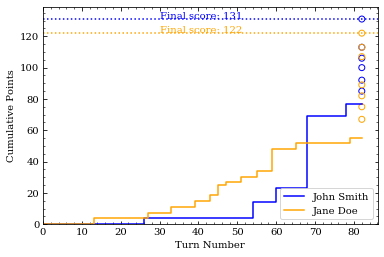

In [9]:
fig, ax = plt.subplots(1,1,
                       squeeze=False)
colors = ['blue', 'orange', 'green', 'red']
sdtype = [('turnNum', float), ('ingame', float), ('points', float)]
for i, playerID in enumerate(playerIDs):
    start = np.array((0, 1, 0), dtype=sdtype)
    rec = cur.execute('''SELECT turnNum,ingame,points FROM scores WHERE gameID={0:d} and playerID={1:d} ORDER BY turnNum'''.format(gameID,
                                                                                                                  playerID[0])).fetchall()
    rec = np.array(rec, dtype=sdtype)
    endT = cur.execute('''SELECT turnNum from scores WHERE gameID={0:d} ORDER BY turnNum DESC LIMIT 1'''.format(gameID)).fetchall()[0][0]
    end = np.array((endT, 1, 0), dtype=sdtype)
    rec = np.hstack((start, rec, end))
    ig = rec['ingame'] == 1
    postscore = np.sum(rec['points'][ig])
    ax[0][0].step(rec['turnNum'][ig],
                  np.cumsum(rec['points'][ig]),
                  where='post',
                  color=colors[i],
                  label=players[playerID[0]])
    ax[0][0].scatter(rec['turnNum'][~ig],
                     postscore + np.cumsum(rec['points'][~ig]),
                     marker='o',
                     facecolor='',
                     edgecolor=colors[i])
    fscore = np.sum(rec['points'])
    ax[0][0].axhline(fscore,
                     ls=':',
                     color=colors[i])
    plt.annotate('Final score: {0:1.0f}'.format(fscore),
                 (30, fscore),
                 color=colors[i])
ax[0][0].set_xlabel('Turn Number')
ax[0][0].set_ylabel('Cumulative Points')
ax[0][0].set_xlim([0, rec['turnNum'][-1]*1.05])
ylims = ax[0][0].get_ylim()
ax[0][0].set_ylim([0, ylims[1]])
ax[0][0].minorticks_on()
ax[0][0].legend(loc='best')

In [10]:
# JOIN the scores and turns tables to get the timesteps for a sample game

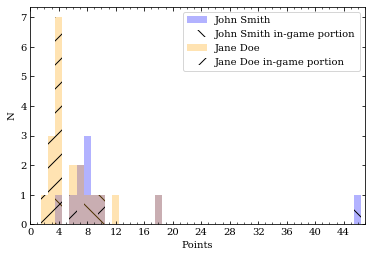

In [11]:
fig, ax = plt.subplots(1, 1,
                       squeeze=False)
hatches = ['\\', '/', '|', '-']
maxpts = cur.execute('''SELECT points FROM scores WHERE gameID={0:d} ORDER BY points DESC LIMIT 1'''.format(gameID)).fetchall()[0][0]
bins = np.arange(0.5, maxpts+1.5, 1)
for i, playerID in enumerate(playerIDs):
    rec = cur.execute('''SELECT points,ingame FROM scores WHERE gameID={0:d} and playerID={1:d}'''.format(gameID,
                                                                                                          playerID[0])).fetchall()
    rec = np.array(rec, dtype=[('points', float), ('ingame', float)])
    ig = rec['ingame'] == 1
    ax[0][0].hist(rec['points'],
                  bins=bins,
                  alpha=0.3,
                  color=colors[i],
                  label=players[playerID[0]])
    ax[0][0].hist(rec['points'][ig],
                  bins=bins,
                  alpha=0.0,
                  color=colors[i],
                  hatch=hatches[i],
                  label=players[playerID[0]] + ' in-game portion')

ax[0][0].set_xticks(np.arange(0, maxpts+1, 4))
ax[0][0].set_xlim([0, maxpts+1])
ax[0][0].minorticks_on()
ax[0][0].tick_params(axis='y', which='minor', left=False, right=False)
ax[0][0].set_ylabel('N')
ax[0][0].set_xlabel('Points')
ax[0][0].legend(loc='best')

## Scores by Type

### Fraction of scores and fraction of points per scoretype

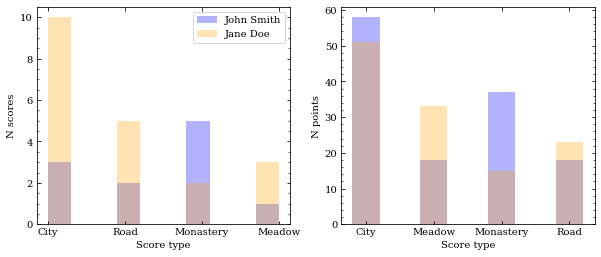

In [12]:
fig, ax = plt.subplots(1,2,
                       squeeze=False,
                       figsize=(10,4))
# get the list of unique scoretypes in this game
stypes = cur.execute('''SELECT DISTINCT scoretype FROM scores WHERE gameID={0:d} ORDER BY scoretype'''.format(gameID)).fetchall()

for i, playerID in enumerate(playerIDs):
    rec = cur.execute('''SELECT points,ingame,scoretype FROM scores WHERE gameID={0:d} and playerID={1:d}'''.format(gameID, playerID[0])).fetchall()
    scores = np.array(rec, dtype=[('points', float), ('ingame', float), ('scoretype', 'S30')])
    pstypes, Ntypes = np.unique(scores['scoretype'], return_counts=True)
    ax[0][0].hist(scores['scoretype'],
                  color=colors[i],
                  alpha=0.3,
                  label=players[playerID[0]])
    for stype in stypes:
        ax[0][1].bar(stype,
                     np.sum(scores['points'][scores['scoretype']==str.encode(stype[0])]),
                     width=0.4,
                     alpha=0.3,
                     color=colors[i])
ax[0][0].set_xlabel('Score type')
ax[0][1].set_xlabel('Score type')
ax[0][0].set_ylabel('N scores')
ax[0][1].set_ylabel('N points')
ax[0][0].minorticks_on()
ax[0][1].minorticks_on()
ax[0][0].tick_params(axis='x', which='minor', bottom=False, top=False)
ax[0][1].tick_params(axis='x', which='minor', bottom=False, top=False)
ax[0][0].legend(loc='best')

## Distribution of time per turn

Turn time for John Smith: median=11s, mean=13s
Turn time for Jane Doe: median=14s, mean=17s


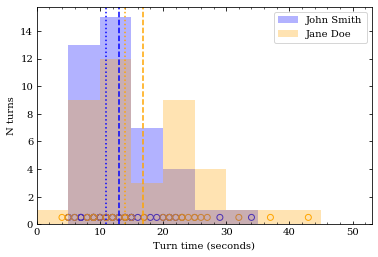

In [13]:
starttime = cur.execute('''SELECT starttime FROM games WHERE gameID={0:d}'''.format(gameID)).fetchall()[0][0]
st = datetime.strptime(starttime, timefmt)
turns = cur.execute('''SELECT time,playerID,turnNum FROM turns WHERE gameID={0:d} ORDER BY time'''.format(gameID)).fetchall()
playerdt = {}
for playerID in playerIDs:
    playerdt[playerID[0]] = []
fig, ax = plt.subplots(1, 1,
                       squeeze=False)

for i, turn in enumerate(turns):
    tt = datetime.strptime(turn[0], timefmt)
    if i > 0:
        prevt = datetime.strptime(turns[i-1][0], timefmt)
        playerdt[turn[1]].append((tt-prevt).total_seconds())
    else:
        playerdt[turn[1]].append((tt-st).total_seconds())
    
maxdt = np.max([np.max(playerdt[x]) for x in playerdt.keys()])
for i, playerID in enumerate(playerIDs):
    ax[0][0].hist(playerdt[playerID[0]],
                  bins=np.arange(0, maxdt+10, 5),
                  color=colors[i],
                  label=players[playerID[0]],
                  alpha=0.3)
    ax[0][0].scatter(playerdt[playerID[0]],
                     0.5 + np.zeros(len(playerdt[playerID[0]])),
                     facecolor='',
                     marker='o',
                     edgecolor=colors[i])
    ax[0][0].axvline(np.mean(playerdt[playerID[0]]),
                     ls='--',
                     color=colors[i])
    ax[0][0].axvline(np.median(playerdt[playerID[0]]),
                     ls=':',
                     color=colors[i])
    print("Turn time for " + players[playerID[0]] + ": median={0:1.0f}s, mean={1:1.0f}s".format(np.median(playerdt[playerID[0]]),
                                                                                    np.mean(playerdt[playerID[0]])))

ax[0][0].legend(loc='best')
ax[0][0].set_xlabel('Turn time (seconds)')
ax[0][0].set_ylabel('N turns')
ax[0][0].set_xlim([0, maxdt+10])
ylims = ax[0][0].get_ylim()
ax[0][0].set_ylim([0, ylims[1]])
ax[0][0].minorticks_on()
ax[0][0].tick_params(axis='y', which='minor', left=False, right=False)

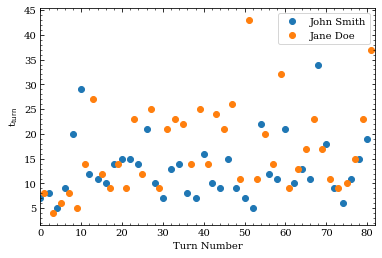

In [14]:
fig, ax = plt.subplots(1, 1, squeeze=False)
turns = np.array(turns,
                 dtype=[('Date', 'S20'),
                        ('playerID', float),
                        ('turnNum', float)])
for i, playerID in enumerate(playerIDs):
    playerturns = turns[turns['playerID']==playerID[0]]
    lastturn = np.max(playerturns['turnNum'])
    ax[0][0].scatter(playerturns['turnNum'],
                     playerdt[playerID[0]],
                     label=players[playerID[0]])
    ax[0][0].set_ylabel(r't$_{\rm turn}$')
    ax[0][0].set_xlabel('Turn Number')

ax[0][0].set_xlim([0, np.max(turns['turnNum'])+1])
ax[0][0].legend(loc='best')
ax[0][0].minorticks_on()

## Closing

Let's cleanly close the database.

In [15]:
conn.close()